In [25]:
# Import packages
import pandas as pd
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 16})

# Import functions
from functions import process_ticker, plot_distributions, preprocessing_df, combined_backtest, add_volatility

**External Links:**

1. The underlying code that generates this document can be found [here](URL) (Github repository).
2. An interactive web app based on this document can be found [here](URL) (Streamlit - work in progress).

# Preamble
## Executive summary
A backtest methodology was used to test modifications to the Black-Scholes Model (BSM) applied to options pricing. It was found that for the historical options data for SPY and QQQ, a student's t distribution implemented in the BSM yields around an order of magnitude improvement in prediction accuracy (Mean Abolute Percentage Error (MAPE)) compared to the standard BSM with the normal distribution.

## Background
Options are a type of financial derivative. They are used by investors either to hedge against unwanted price movement in the underlying asset or to speculate on changes in the underlying price. The focus of this study is on speculating. There are four core types of options trades:

| Trade type | Reason for entering trade |
| --- | --- |
| Buy a call | The trader believes that the price of the underlying asset will **go above** a certain strike price by a certain expiration date. |
| Buy a put | The trader believes that the price of the underlying asset will **go below** a certain strike price by a certain expiration date. |
| Sell a call | The trader believes that the price of the underlying asset will **not go above** a certain strike price by a certain expiration date. |
| Sell a put | The trader believes that the price of the underlying asset will **not go below** a certain strike price by a certain expiration date. |

The underlying idea behind the trading strategy used in this study is not to predict the direction but to find possible trades that are believed to be 'mispriced'. In this study, options are priced using the Black-Scholes Model.

## Research question
The Black-Scholes Model uses the normal distribution. It has been discussed in literature that a student's t distribution would be more appropriate for modelling financial asset returns, due to their 'fatter tails' i.e. a high occurrence of extreme movements. Based on this idea, the author hypothesises that the Black-Scholes Model could be improved by using a student's t distribution instead of a normal distribution. The research question then becomes:

What effect, if any, does the distribution type have on the trade outcome prediction accuracy? Or more specifically, does the student's t distribution have better prediction accuracy than the normal distribution?

## Assuptions

1. The historical data used is accurate.
2. There is no slippage or any related change in the price recorded in the historical data.
3. The parameters used in the distribution function, besides the standard deviation, remain constant throughout all time.
4. The Implied Volatility is 'correct' (what exactly this means is beyond the scope of this study).
5. The risk-free rate of return is equal to the 10-year US Treasury Bond yield.

## Methodology
Historical options prices of SPY (S&P 500, from 2010 to 2023) and QQQ (NASDAQ 100, from 2012 to 2023) are traded.

The following steps are followed:

1. The first part of the hypothesis is that the student's t distribution should fit historical returns. This hypothesis is tested with historical returns that occurred before the start of the options data.
2. Two of the inputs to the Black-Scholes Model are obtained - the implied volatility of each ticker and the risk free rate of return.
3. The second part of the hypothesis is that an improved fit of the distribution type to the asset returns should result in an improvement in the prediction accuracy of the Black-Scholes Model. This is tested by computing selected trades on historical options price data of SPY (S&P 500, from 2010 to 2023) and QQQ (NASDAQ 100, from 2012 to 2023).

The following requirements are used to select trades:

| Parameter | Range selected | Reason |
| --- | --- | --- |
| Trade volume | Greater or equal to 1 | A high number of trades is required to test the accuracy of a stochastic pricing model |
| Expected value | Greater than 0 | It has been found in literature as well as the author's own research that pricing models aren't too accurate for negative expected values. |
| Days to expiration (DTE) | Less than or equal to 1 | Longer DTE values are affected more and more by underlying 'fundamental' price movements. The goal of this study is to focus on 'purely randmom' price movements. |

# Analysis

In [26]:
# Inputs
DTE_max = 1
DTE_min = 0
volume_min = 0
required_probability_per = 0
required_EV_per = 0

In [27]:
tickers = ["SPY", "QQQ"]
tickers_underlying = ["^GSPC", "^NDX"]

In [28]:
## Open dataframes from pickle files
# Obtain SPY options dataframe
ticker = tickers[0]
options_df_SPY = pd.read_pickle(ticker+"_options_data.pkl")

# Obtain QQQ options dataframe
ticker = tickers[1]
options_df_QQQ = pd.read_pickle(ticker+"_options_data.pkl")

## Comparison of distributions
The first part of the hypothesis is that the student's t distribution should fit historical returns. This hypothesis is tested with historical returns that occurred before the start of the options data.

The fit of the distribution type to historical data is displayed in two methods:

1. Visually: A histogram is plotted along with the fitted distributions. It can bee seen which distributions better fit the data.
2. Numerically: The difference between the data (histogram) and the fitted distribution is computed using the statistical figure of merit of Mean Abolute Percentage Error (MAPE). A lower MAPE value signifies a bettter fit.

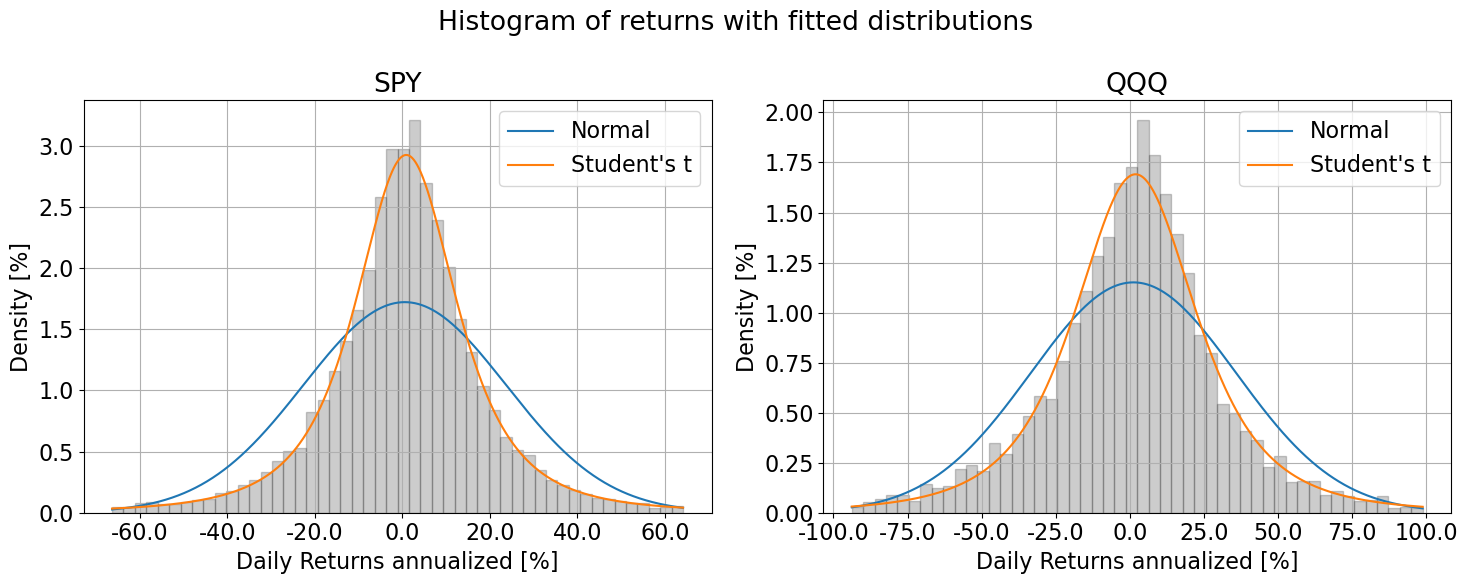

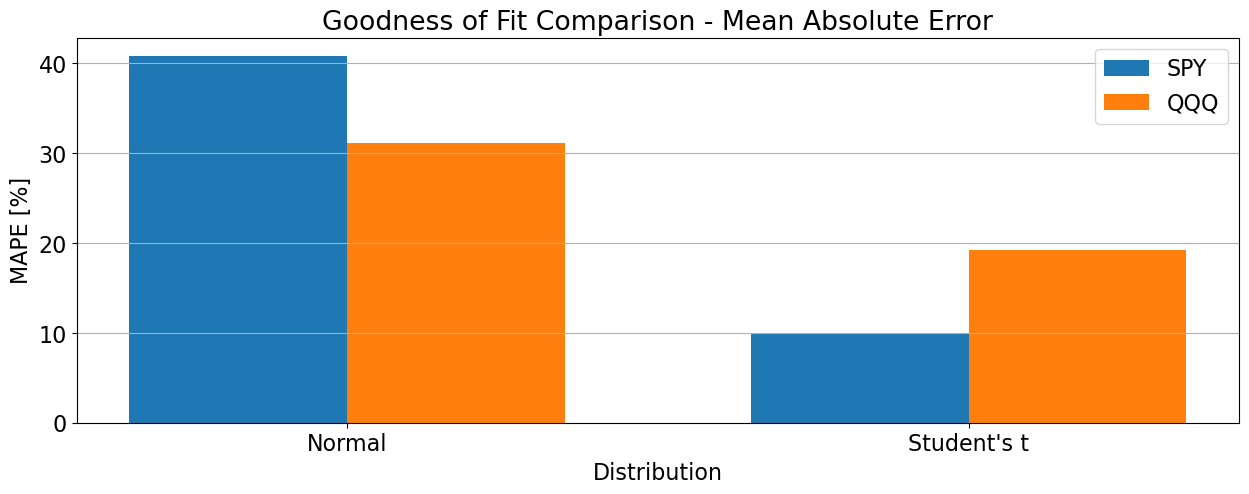

In [29]:
# Process tickers
results = {}
for i, ticker in enumerate(tickers):
    results[ticker] = process_ticker(tickers_underlying[i], start_date='1900-01-01', end_date='2009-12-31')

# First Plot: 1x2 Subplots
plt.figure(figsize=(15, 6), layout='tight')
plt.suptitle('Histogram of returns with fitted distributions')
for i, ticker in enumerate(tickers, 1):

    ax = plt.subplot(1, 2, i)
    filtered_data, mape_values, distribution_names, distribution_params, norm_mu, t_mu, t_df = results[ticker]
    plot_distributions(ax, ticker, filtered_data, distribution_params, distribution_names)

    if i == 1:
        [norm_mu_SPY, t_mu_SPY, t_df_SPY] = [norm_mu, t_mu, t_df]
    elif i == 2:
        [norm_mu_QQQ, t_mu_QQQ, t_df_QQQ] = [norm_mu, t_mu, t_df]

plt.tight_layout()
plt.show()

# Second Plot: Double Bar Chart
plt.figure(figsize=(15, 5))
bar_width = 0.35
x = np.arange(len(distribution_names))

for i, ticker in enumerate(tickers):
    mape_values = results[ticker][1]
    plt.bar(x + i * bar_width, mape_values, bar_width, label=ticker)

plt.xticks(x + bar_width / 2, distribution_names)
plt.title('Goodness of Fit Comparison - Mean Absolute Error')
plt.xlabel('Distribution')
plt.ylabel('MAPE [%]')
plt.legend()
plt.grid(axis='y')
plt.show()

It is visually and numerically shown that the student's t distribution results in a better fit than the normal distribution, for both SPY and QQQ.

## Trade outcome prediction
The second part of the hypothesis is that an improved fit of the distribution type to the asset returns should result in an improvement in the prediction accuracy of the Black-Scholes Model. This is tested by computing selected trades on historical options price data of SPY (S&P 500, from 2010 to 2023) and QQQ (NASDAQ 100, from 2012 to 2023).

The following requirements are used to select trades:

| Parameter | Range selected | Reason |
| --- | --- | --- |
| Trade volume | Greater or equal to 1 | A high number of trades is required to test the accuracy of a stochastic pricing model |
| Expected value | Greater than 0 | It has been found in literature as well as the author's own research that pricing models aren't too accurate for negative expected values. |
| Days to expiration (DTE) | Less than or equal to 1 | Longer DTE values are affected more and more by underlying 'fundamental' price movements. The goal of this study is to focus on 'purely randmom' price movements. |

The MAPE of the difference between the expected value (predicted trade result) and actual trade result is computed and plotted versus the number of trades. The predicted trade result and actual trade result versus time is shown in Appendix A.

In [30]:
options_df_SPY = preprocessing_df(options_df_SPY, DTE_min, DTE_max)
options_df_QQQ = preprocessing_df(options_df_QQQ, DTE_min, DTE_max)

In [31]:
## Volatility
# SPY
IV_SPY = (yf.download("^VIX", start=options_df_SPY['[QUOTE_DATE]'].iloc[0], end=options_df_SPY['[QUOTE_DATE]'].iloc[-1],\
                      progress=False))['Adj Close'] * 1/100
options_df_SPY = add_volatility(options_df_SPY, IV_SPY)

# QQQ
IV_QQQ = (yf.download("^VXN", start=options_df_QQQ['[QUOTE_DATE]'].iloc[0], end=options_df_QQQ['[QUOTE_DATE]'].iloc[-1],\
                      progress=False))['Adj Close'] * 1/100
options_df_QQQ = add_volatility(options_df_QQQ, IV_QQQ)

In [32]:
# Output arrays
df_buy_call_mean_array = np.empty((2,2), dtype=object)
df_buy_put_mean_array = np.empty((2,2), dtype=object)

In [33]:
# SPY
for k, dist_select in enumerate(['norm', 't']):
        
        df_buy_call_mean_array[0,k], df_buy_put_mean_array[0,k] = combined_backtest(options_df_SPY, norm_mu_SPY, t_mu_SPY,\
                                                   t_df_SPY, dist_select, required_probability_per,\
                                                        required_EV_per, volume_min)

In [34]:
# QQQ
for k, dist_select in enumerate(['norm', 't']):
        
        df_buy_call_mean_array[1,k], df_buy_put_mean_array[1,k] = combined_backtest(options_df_QQQ, norm_mu_QQQ, t_mu_QQQ,\
                                                   t_df_SPY, dist_select, required_probability_per,\
                                                        required_EV_per, volume_min)

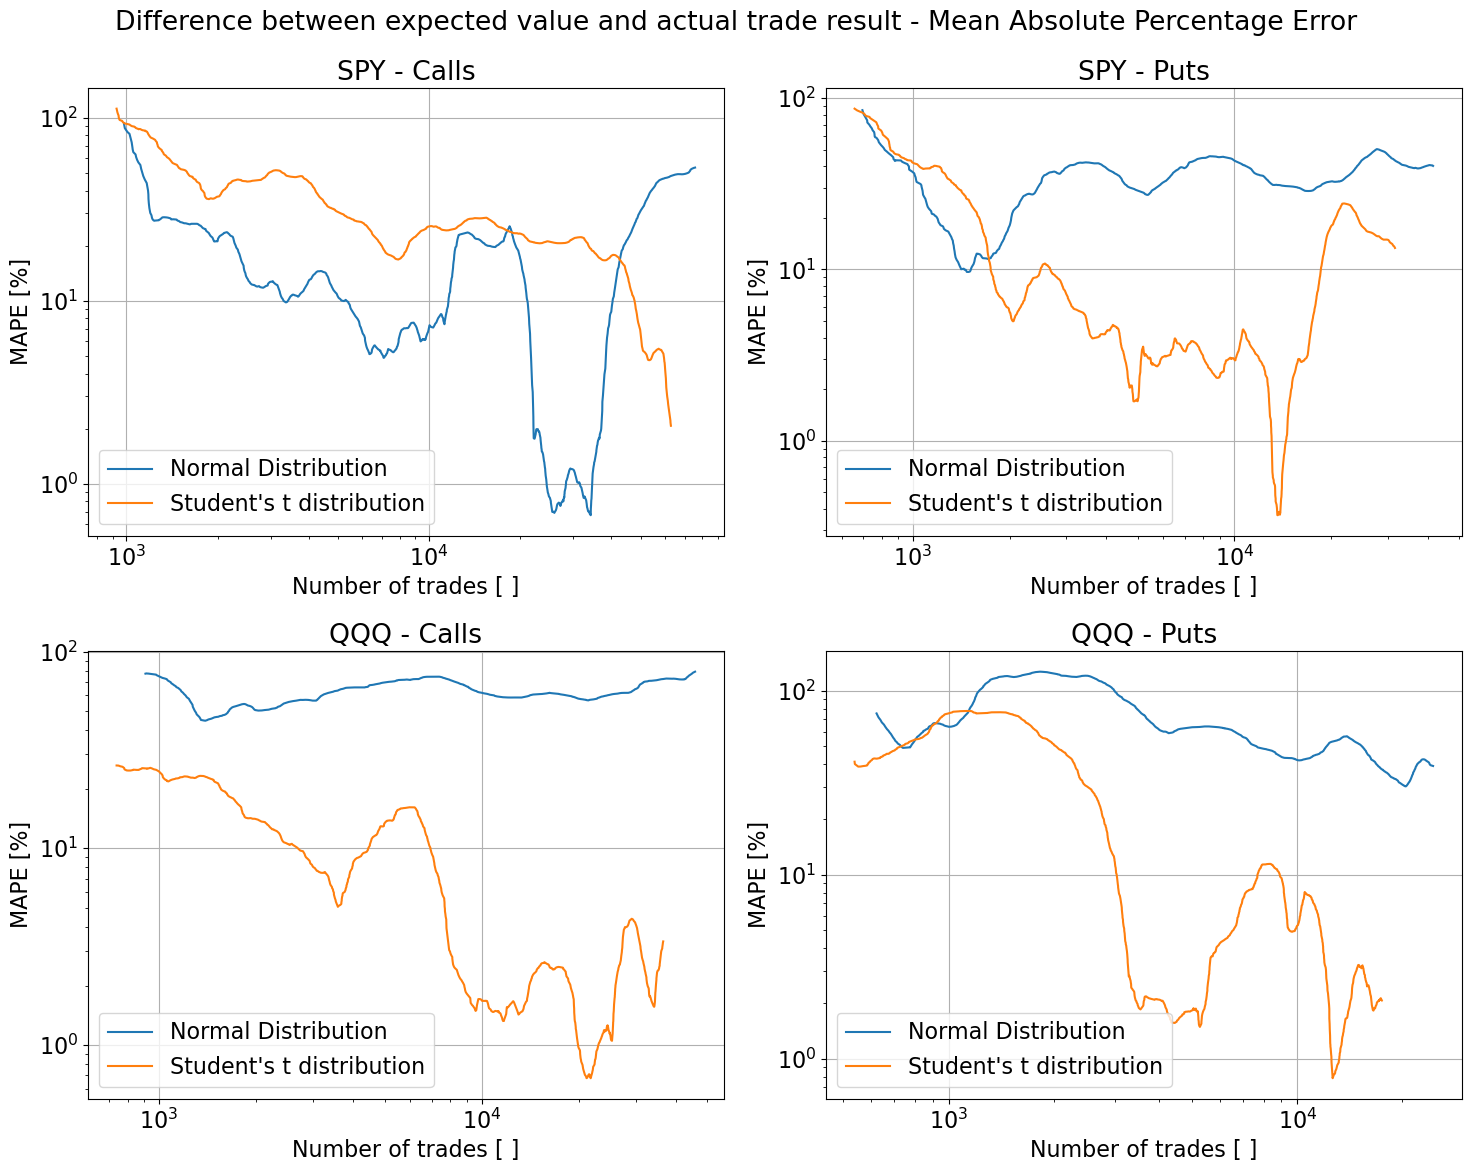

In [35]:
# MAPE
plt.figure(figsize=(15, 12), layout='tight')
plt.suptitle('Difference between expected value and actual trade result - Mean Absolute Percentage Error')

plt.subplot(2,2,1)
plt.plot(df_buy_call_mean_array[0,0]['N trades total'], df_buy_call_mean_array[0,0]['MAPE'].rolling(window=100).mean(), label='Normal Distribution')
plt.plot(df_buy_call_mean_array[0,1]['N trades total'], df_buy_call_mean_array[0,1]['MAPE'].rolling(window=100).mean(), label='Student\'s t distribution')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MAPE [%]')
plt.xlabel('Number of trades [ ]')
plt.title('SPY - Calls')

plt.subplot(2,2,2)
plt.plot(df_buy_put_mean_array[0,0]['N trades total'], df_buy_put_mean_array[0,0]['MAPE'].rolling(window=100).mean(), label='Normal Distribution')
plt.plot(df_buy_put_mean_array[0,1]['N trades total'], df_buy_put_mean_array[0,1]['MAPE'].rolling(window=100).mean(), label='Student\'s t distribution')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MAPE [%]')
plt.xlabel('Number of trades [ ]')
plt.title('SPY - Puts')

plt.subplot(2,2,3)
plt.plot(df_buy_call_mean_array[1,0]['N trades total'], df_buy_call_mean_array[1,0]['MAPE'].rolling(window=100).mean(), label='Normal Distribution')
plt.plot(df_buy_call_mean_array[1,1]['N trades total'], df_buy_call_mean_array[1,1]['MAPE'].rolling(window=100).mean(), label='Student\'s t distribution')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MAPE [%]')
plt.xlabel('Number of trades [ ]')
plt.title('QQQ - Calls')

plt.subplot(2,2,4)
plt.plot(df_buy_put_mean_array[1,0]['N trades total'], df_buy_put_mean_array[1,0]['MAPE'].rolling(window=100).mean(), label='Normal Distribution')
plt.plot(df_buy_put_mean_array[1,1]['N trades total'], df_buy_put_mean_array[1,1]['MAPE'].rolling(window=100).mean(), label='Student\'s t distribution')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MAPE [%]')
plt.xlabel('Number of trades [ ]')
plt.title('QQQ - Puts')

plt.show()

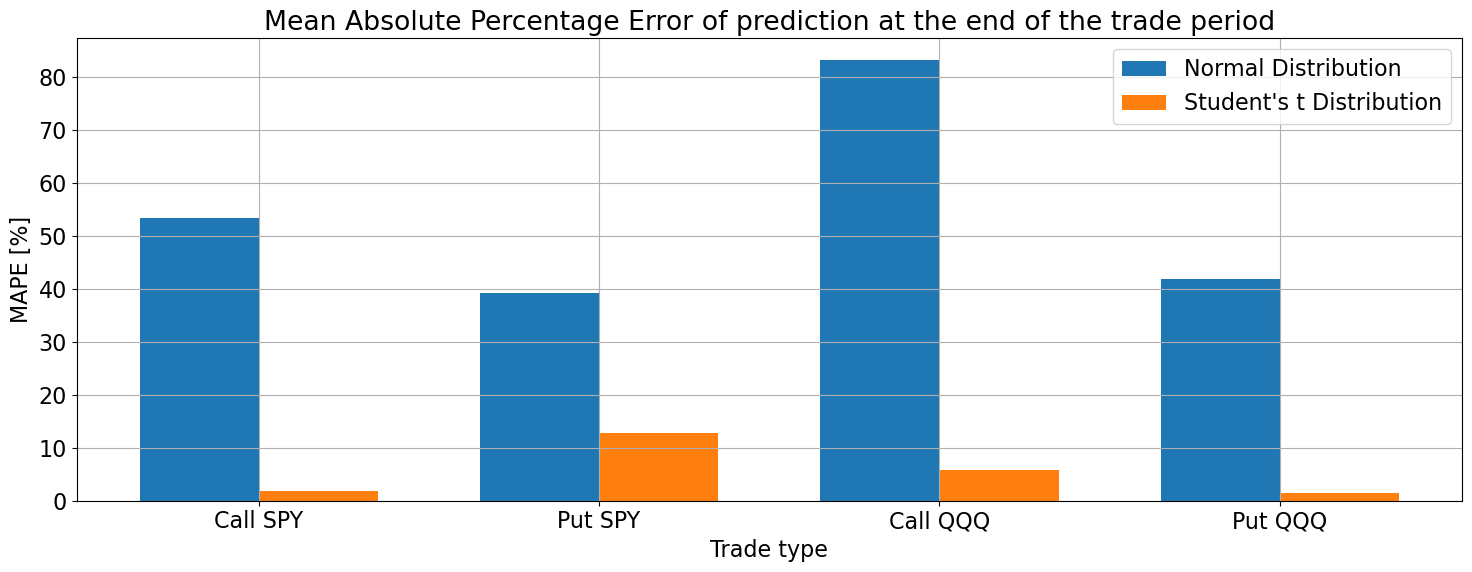

In [36]:
# MAPE Bar chart
# x Data
x_labels = ['Call SPY', 'Put SPY', 'Call QQQ', 'Put QQQ']

# legend data
legend_data = ['Normal Distribution', 'Student\'s t Distribution']

# y data Normal Distribution
y_data_norm = np.empty(4)
y_data_norm[0] = df_buy_call_mean_array[0,0]['MAPE'][-1]
y_data_norm[1] = df_buy_put_mean_array[0,0]['MAPE'][-1]
y_data_norm[2] = df_buy_call_mean_array[1,0]['MAPE'][-1]
y_data_norm[3] = df_buy_put_mean_array[1,0]['MAPE'][-1]

# y data Normal Distribution
y_data_t = np.empty(4)
y_data_t[0] = df_buy_call_mean_array[0,1]['MAPE'][-1]
y_data_t[1] = df_buy_put_mean_array[0,1]['MAPE'][-1]
y_data_t[2] = df_buy_call_mean_array[1,1]['MAPE'][-1]
y_data_t[3] = df_buy_put_mean_array[1,1]['MAPE'][-1]

# Plot
plt.figure(figsize=(15, 6))

# Double bar chart plot
x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

# Create the bars
plt.bar(x - width/2, y_data_norm, width, label=legend_data[0])
plt.bar(x + width/2, y_data_t, width, label=legend_data[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Trade type')
plt.ylabel('MAPE [%]')
plt.title('Mean Absolute Percentage Error of prediction at the end of the trade period')
plt.xticks(x, x_labels)
plt.grid()
plt.legend()
# plt.yscale('log')

plt.tight_layout()
plt.show()

It is shown that the MAPE of the prediction accuracy is better (lower) with the student's t distribution versus the normal distribution. For the student's t distribution, the MAPE reduces versus the number of trades. This is to be expected for an accurate pricing model (e.g. when flipping a perfect coin, only after an infinite number of attempts, will the split be 50/50). There is no clear trend of the MAPE reducing versus number of trades for the normal distribution.

# Concluding remarks
## Conclusion
For the sample data used in this study, it has been shown that using the Black-Scholes model modified using the student's t distribution (instead of the normal distribution) significantly improves the prediction accuracy of the pricing model. This is quantified by around an order of magnitude improvement in terms of MAPE (of realised value versus expected value), the figure of merit used for prediction accuracy in this study.

## Next steps

1. For the sake of completeness, the study done here should include selling call and put options, and possibly other tickers.
2. If the results of this study are extrapolated, an additional hypothesis would be that the estimation of implied volatility could be improved by using the student's t distribution instead of the normal distribution currently used. This hypothesis should be tested to see if this approach could even further improve the prediction accuracy.

## Caveats
One might look at this study and draw the conclusion that if you now have an accurate pricing model, it should now be possible to beat the market. The following cautions should be raised regarding this study:

1. The minimum trade volume used is 1 open trade. Many of these trades are therefore illiquid, and if these trades occurred in reality, the slippage could be significant, causing the expected value to possibly go from positive to negative during the execution of the trade.
2. It has been shown that at least 10 000 trades are required for the predicted expected value to approach the trade outcome. This is unfortunately a feature (and not a bug) of stochastic pricing models, that many attempts are required before the prediction starts being meaningful. It is therefore probabilistically likely to first lose money before making money.

# Appendix A

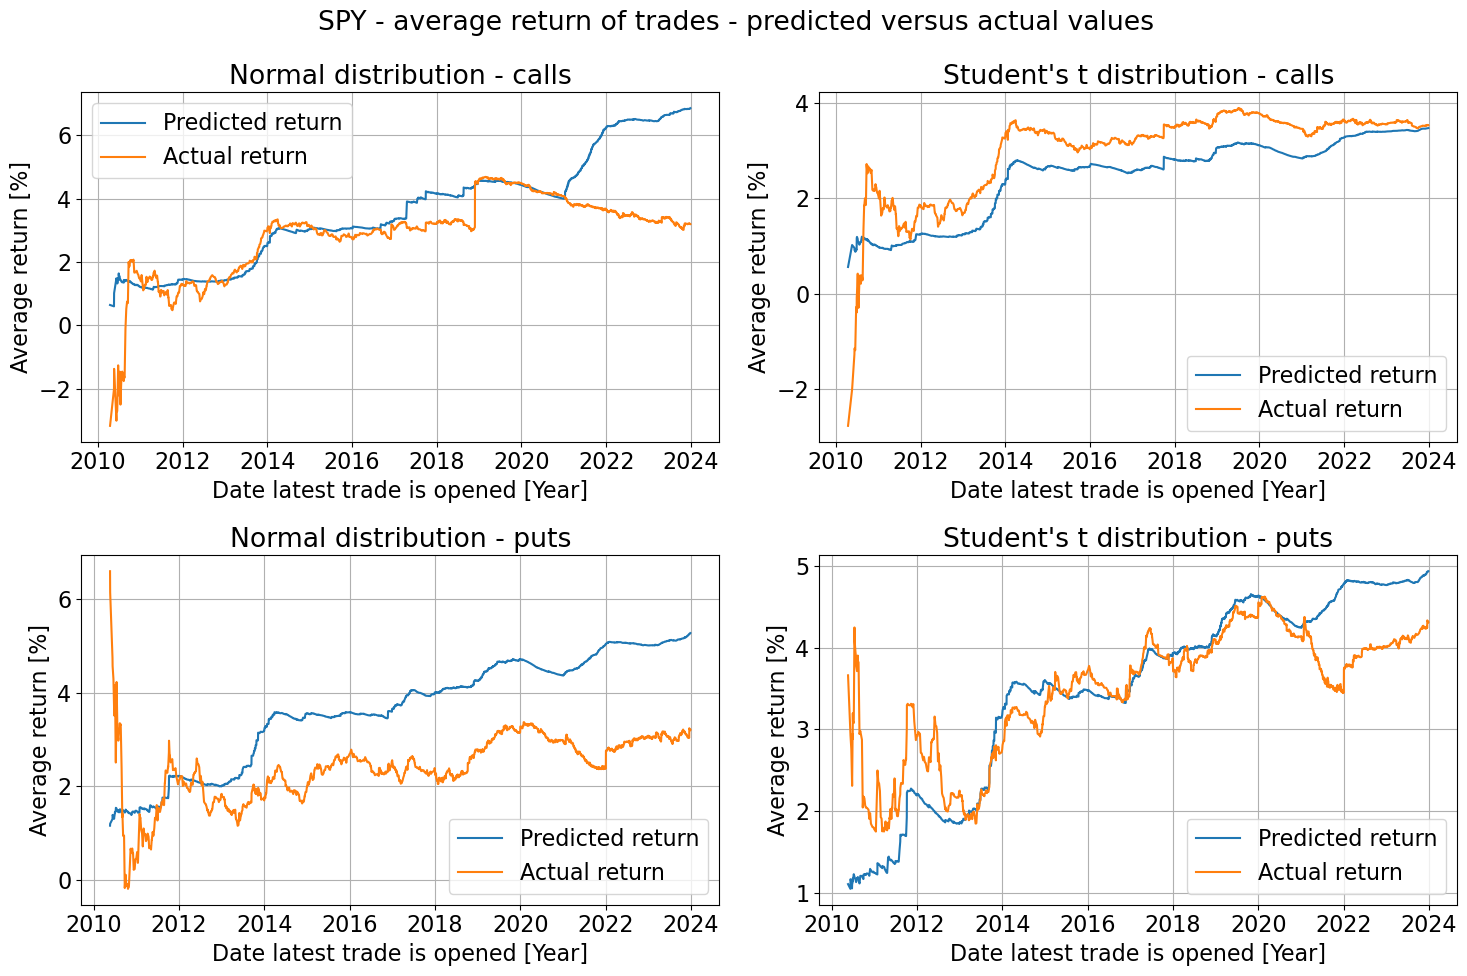

In [37]:
# SPY
plt.figure(figsize=(15, 10))
plt.suptitle('SPY - average return of trades - predicted versus actual values')

plt.subplot(2,2,1)
plt.plot(df_buy_call_mean_array[0,0].index, df_buy_call_mean_array[0,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_call_mean_array[0,0].index, df_buy_call_mean_array[0,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Normal distribution - calls')

plt.subplot(2,2,2)
plt.plot(df_buy_call_mean_array[0,1].index, df_buy_call_mean_array[0,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_call_mean_array[0,1].index, df_buy_call_mean_array[0,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Student\'s t distribution - calls')

plt.subplot(2,2,3)
plt.plot(df_buy_put_mean_array[0,0].index, df_buy_put_mean_array[0,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_put_mean_array[0,0].index, df_buy_put_mean_array[0,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Normal distribution - puts')

plt.subplot(2,2,4)
plt.plot(df_buy_put_mean_array[0,1].index, df_buy_put_mean_array[0,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_put_mean_array[0,1].index, df_buy_put_mean_array[0,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Student\'s t distribution - puts')

plt.tight_layout()
plt.show()

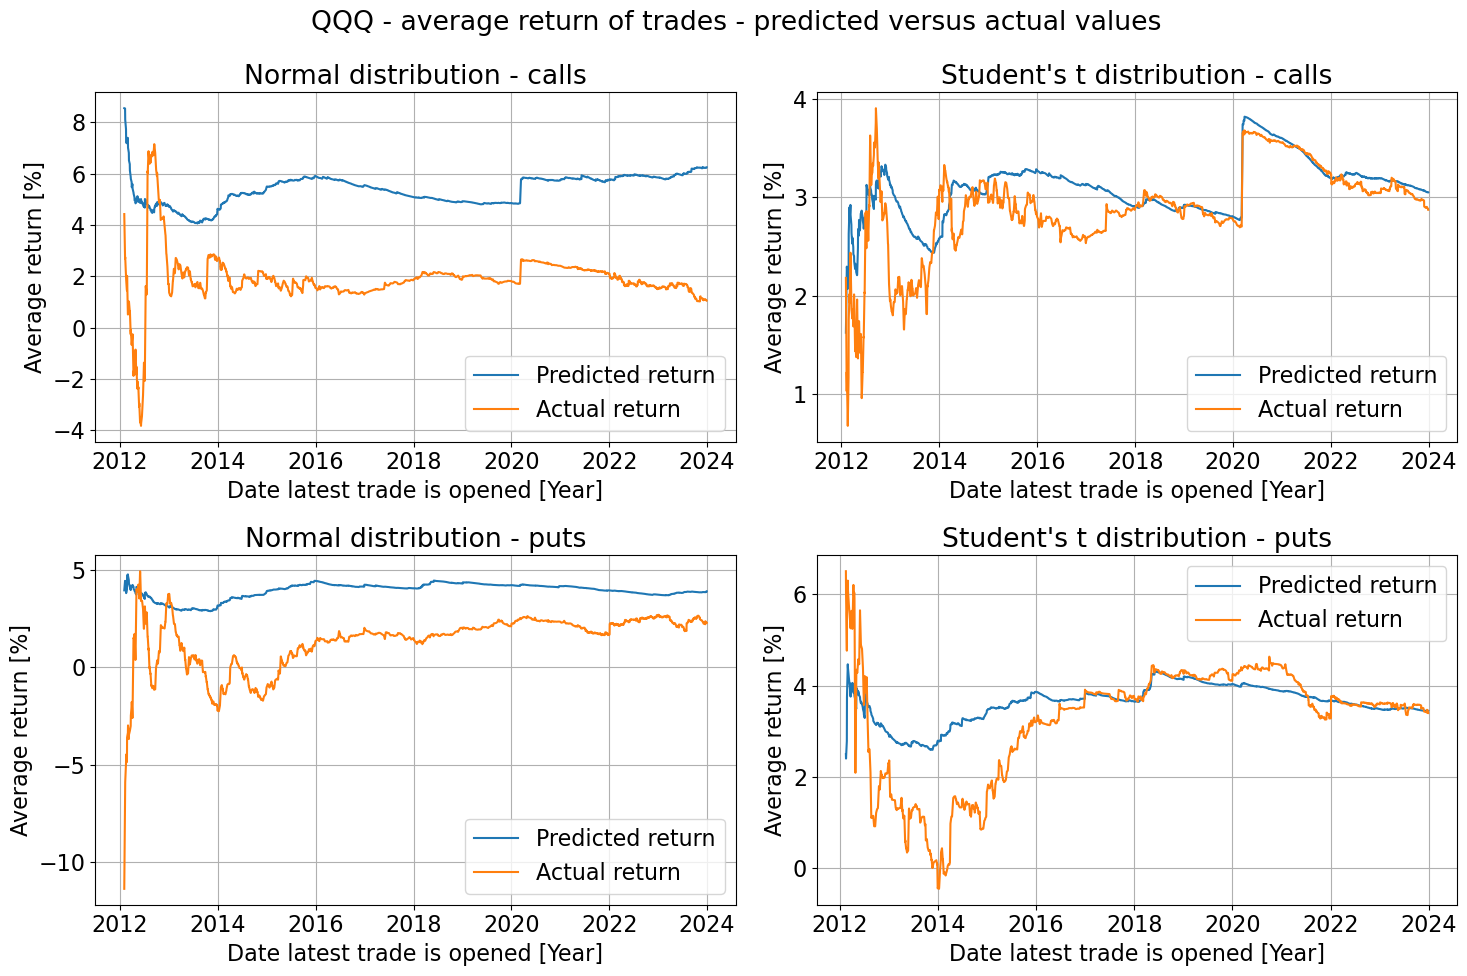

In [38]:
# SPY
plt.figure(figsize=(15, 10))
plt.suptitle('QQQ - average return of trades - predicted versus actual values')

plt.subplot(2,2,1)
plt.plot(df_buy_call_mean_array[1,0].index, df_buy_call_mean_array[1,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_call_mean_array[1,0].index, df_buy_call_mean_array[1,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Normal distribution - calls')

plt.subplot(2,2,2)
plt.plot(df_buy_call_mean_array[1,1].index, df_buy_call_mean_array[1,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_call_mean_array[1,1].index, df_buy_call_mean_array[1,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Student\'s t distribution - calls')

plt.subplot(2,2,3)
plt.plot(df_buy_put_mean_array[1,0].index, df_buy_put_mean_array[1,0]['EV% mean'], label='Predicted return')
plt.plot(df_buy_put_mean_array[1,0].index, df_buy_put_mean_array[1,0]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Normal distribution - puts')

plt.subplot(2,2,4)
plt.plot(df_buy_put_mean_array[1,1].index, df_buy_put_mean_array[1,1]['EV% mean'], label='Predicted return')
plt.plot(df_buy_put_mean_array[1,1].index, df_buy_put_mean_array[1,1]['actual return % mean'], label='Actual return')
plt.legend()
plt.grid()
plt.xlabel('Date latest trade is opened [Year]')
plt.ylabel('Average return [%]')
plt.title('Student\'s t distribution - puts')

plt.tight_layout()
plt.show()